In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, json
from IPython.display import display, clear_output, IFrame
import datetime

from tqdm import tqdm, tqdm_notebook, tnrange

import scipy.io as sio # loadmat

%matplotlib inline
%config InlineBackend.figure_format = 'svg' # 'svg', 'retina'
plt.style.use('seaborn-white')

In [3]:
from scipy.optimize import least_squares, curve_fit

# Nonlinear Curve Fit

A nonlinear equation $ y = f\left( x|\theta \right) $ where $x$ is the independent variable and $\theta$ is the set of parameters, could be fit using two different approoaches:  

1. Use `scipy.optimize.least_squares`: minimize the error between `y` and `y_pred`.  
1. Use `scipy.optimize.curve_fit`: fit curve `y` with model `f(x, *params)`

The following shows how to implement both.

# Generate Dummy Data

`x` and `y`.

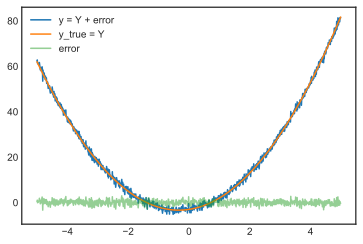

In [72]:
def make_plot(xdata, ydata, y_pred=None, y_true=None, params_pred=None, params_true=None):
    plt.plot(xdata, ydata, label='original', lw=0.3)
    if y_true is not None:
        plt.plot(xdata, y_true, 'y-', label='y_true = f(x, a={:.3f}, b={:.3f}, c={:.3f})'.format(*params_true), lw=2, alpha=0.9)
    if y_pred is not None:
        plt.plot(xdata, y_pred, 'r--', label='y_pred = f(x, a={:.3f}, b={:.3f}, c={:.3f})'.format(*params_pred), lw=1, alpha=0.5)
    plt.legend()
    plt.show()
    
def f(x, a=3, b=2, c=-3):
    return a*x**2 + b*x + c

def gen_f(x, a=3, b=2, c=-3, random_normal_error='N(0,1)', random_seed = 0):
    y = f(x, a=a, b=b, c=c)
    if random_seed is not None:
        np.random.seed = random_seed
    mu, sigma = random_normal_error.split('(')[1].split(')')[0].split(',')
    mu, sigma = int(mu), int(sigma)
    error = sigma*np.random.randn(x.size).reshape(x.shape) + mu    
    return (y, error)

x = np.arange(-5, 5, 0.01)
a, b, c = 3, 2, -3
Y, error = gen_f(x, a=a, b=b, c=c, random_normal_error='N(0,1)', random_seed = 0)
y = Y + error

plt.plot(x,y, label='y = Y + error')
plt.plot(x,Y, label='y_true = Y')
plt.plot(x,error, label='error', alpha=0.5)
plt.legend()
plt.show()

# Apply `curve_fit`

Constrain the optimization to the region of `-10 <= a <= 30`, `0 <= b <= np.inf` and `-10 <= c <= 20`:

In [75]:
popt, pcov = curve_fit(f, x, y, bounds=([-10., 0., -10.], [30., np.inf, 20.]))
y_pred = f(x, *popt)
popt # final a, b, c

array([ 3.00111211,  1.97806673, -2.9464465 ])

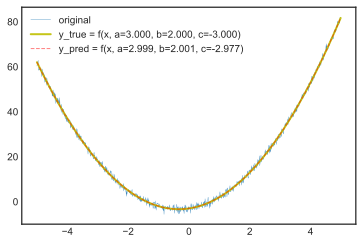

In [64]:
make_plot(x, y, y_pred=y_pred, y_true=Y, params_pred=popt, params_true=[a, b, c])

# Apply `least_square`

**Status**: `int`

>-1 : improper input parameters status returned from MINPACK.  
0 : the maximum number of function evaluations is exceeded.  
1 : gtol termination condition is satisfied.  
2 : ftol termination condition is satisfied.  
3 : xtol termination condition is satisfied.  
4 : Both ftol and xtol termination conditions are satisfied.  

## Define Functions: `residual()` and `fmin()`

In [51]:
def residual(x, y, a, b, c):
    residual = y - f(x, a=a, b=b, c=c)
    return residual
    
def fmin(W, x, y):
    a, b, c = W
    return residual(x, y, a, b, c)

## Estimate Solution

In [52]:
W0 = np.array([a, b, c])
res = least_squares(fmin, W0, args=(x, y), bounds=([-10., 0., -10.], [30., np.inf, 20.]))

Show the result (a structured array) keys.

In [74]:
print(res.keys())
Wf = res['x'] # final values of a, b, c
print('Status: {}'.format(res['status']))

dict_keys(['x', 'cost', 'fun', 'jac', 'grad', 'optimality', 'active_mask', 'nfev', 'njev', 'status', 'message', 'success'])
Status: 2


## Make Plot

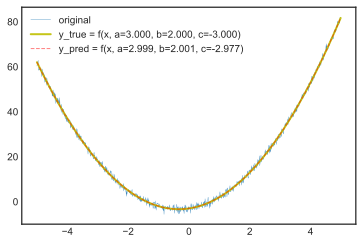

In [65]:
make_plot(x, y, y_pred=y- res['fun'], y_true=Y, params_pred=res['x'], params_true=[a, b, c])